# Load modules

In [1]:
#%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
import matplotlib.pyplot as plt
import math
import numpy as np
import pycuda.autoinit
import pycuda.driver as cuda
import pycuda.compiler
from pycuda.compiler import SourceModule
import sys
import geebls
import gfilter
import getstat
import read_keplerlc as kep

# Loading Light Curves

In [2]:
start = time.time()
dirlist=["/sharksuck/kic/data/0107/010748390","/sharksuck/kic/data/0082/008219268"]
lc,tu,n,ntrue,nq,inval=kep.load_keplc(dirlist)
elapsed_time = time.time() - start
print (("2 :{0}".format(elapsed_time)) + "[sec]")

2 :1.1200170516967773[sec]


Here, n=72000 is divisible by 1000. Later, one can use 1000 as nby when detrending.  

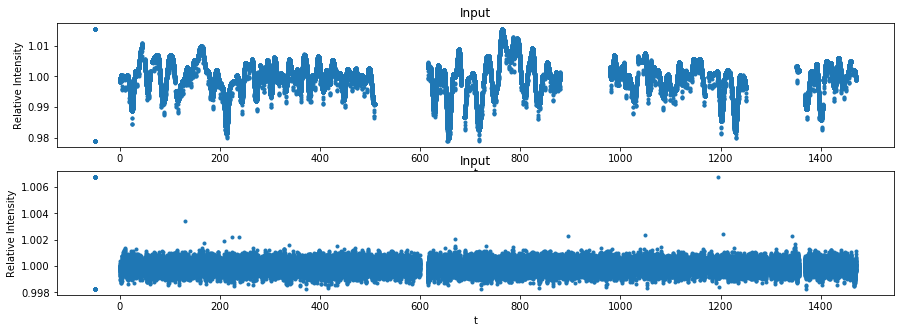

In [3]:
fig = plt.figure(figsize=(15,5))
minnq=np.min([nq,4])
for j in range(0,minnq):
    ax=fig.add_subplot(minnq,1,j+1)
    ax.plot(tu[:,j],lc[:,j],".")
    #plt.ylim(-0.025,0.125)
    plt.title("Input")
    plt.xlabel("t")
    plt.ylabel("Relative Intensity")
plt.show()

# Detrend by gfilter

In [4]:
##detrend (directly use)
#lc=np.array(lc,order="C")
nby=1000 ## of thread
dev_imgout=gfilter.get_detrend(lc,nby=nby,nbx=1,r=16,isw=0,osw=1) #detrend

ydim= 72000 xdim= 2
elapsed_time:0.10536742210388184[sec]


In [5]:
##detrend (read from device)
offset,imgout = gfilter.get_offset(n,nq,dev_imgout,tu)
print(offset)

[ -4.30530381e-05  -4.97690493e-08]


## Load and Plot Detrended LCs (not necessary for analysis)

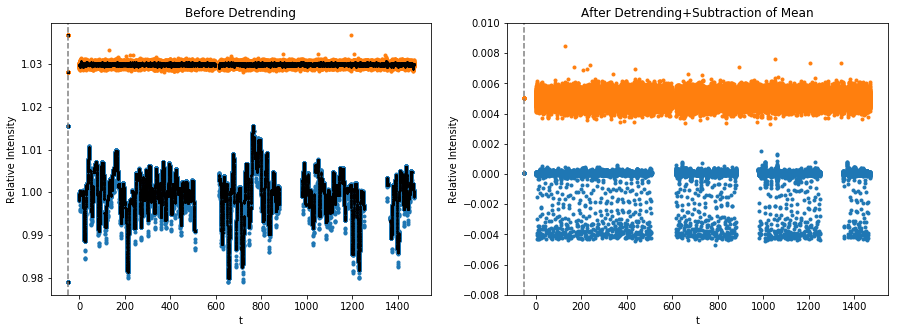

In [6]:
    imgout=imgout-offset  
    #plot
    fig = plt.figure(figsize=(15,5))
    ax=fig.add_subplot(121)
    #plt.ylim(-0.025,0.125)
    for j in range(0,np.min([nq,2])):
        ax.plot(tu[:,j], (lc[:,j]+0.03*j),".")
        ax.plot(tu[:,j], (lc[:,j]-imgout[:,j]+0.03*j),".",c="black",markersize=1.5)
    plt.axvline(inval,color="gray",ls="dashed")
    plt.title("Before Detrending")
    plt.xlabel("t")
    plt.ylabel("Relative Intensity")
    ax=fig.add_subplot(122)
    for j in range(0,np.min([nq,2])):
        ax.plot(tu[:,j], imgout[:,j]+0.005*j,".")
    plt.axvline(inval,color="gray",ls="dashed") #masked data
    plt.ylim(-0.008,0.01)
    plt.title("After Detrending+Subtraction of Mean")
    plt.xlabel("t")
    plt.ylabel("Relative Intensity")
    plt.show()

# BLS fitting by gbls

In [7]:
    #gbls setting
    qmi = 0.01
    qma = 0.1
    fmin = 0.05 
    df = 0.0001
    nf = 1024*16*2 #should be power of 2
    nb = 1024
    print("Pmin=",1/(fmin+nf*df),"[d] Pmax=",1/fmin,"[d]")
    #ntrue=n #temporary

Pmin= 0.30058915474329684 [d] Pmax= 20.0 [d]


In [8]:
    tu=np.array(tu,order="C").astype(np.float32)
#    imgout=np.array(imgout,order="F").astype(np.float32)
    #lc=np.copy(imgout)
    #gbls
    start = time.time()
    dev_offset = cuda.mem_alloc(offset.astype(np.float32).nbytes)
    cuda.memcpy_htod(dev_offset,offset.astype(np.float32))
    
    dev_ntrue = cuda.mem_alloc(ntrue.nbytes)
    cuda.memcpy_htod(dev_ntrue,ntrue)
    
    dev_tu = cuda.mem_alloc(tu.astype(np.float32).nbytes)
    cuda.memcpy_htod(dev_tu,tu.astype(np.float32))
    
    blsp=np.zeros(nf*nq).astype(np.float32)
    dev_blsp = cuda.mem_alloc(blsp.nbytes)
    
    source_module=geebls.gbls_module()
    nthread=512
    pkernel=source_module.get_function("geebls")
    
    ##compute kma,kmi,kkmi
    kma=int(qma*nb)+1
    kmi=int(qmi*nb)
    kkmi=int(n*qmi)
    sharedsize=int(4*(nb+kma)*2+4*nb)
    pkernel(dev_blsp,dev_imgout,dev_tu,dev_offset,dev_ntrue,\
            np.uint32(n),np.uint32(nf),np.uint32(nb),\
            np.uint32(kma),np.uint32(kmi),np.uint32(kkmi),\
            np.float32(fmin),np.float32(df),\
            block=(nthread,1,1), grid=(int(nf),int(nq)),shared=sharedsize)
    #cuda.memcpy_dtoh(blsp,dev_blsp)
    #print(blsp)

    elapsed_time = time.time() - start
    print (("gbls :{0}".format(elapsed_time)) + "[sec] for # of batch="+str(nq))

gbls :0.09619688987731934[sec] for # of batch=2


# Extract Statistics

In [9]:
Pest,sde=getstat.get_blsstat(dev_blsp,nf,nq,df,fmin)

TypeError: get_blsstat() missing 2 required positional arguments: 'df' and 'fmin'

In [14]:
print(Pest)
print(sde)

[4.8875855327468232, 6.2460961898813236]
[57.451964047691128, 25.089381267192479]


## Show the BLS spectra (not necessary for analysis)

In [15]:
#load BLS spectra on device
cuda.memcpy_dtoh(blsp,dev_blsp)
print(blsp)

[  9.53714971e-06   1.27769245e-05   1.28807987e-05 ...,   5.21100583e-06
   4.74012631e-06   5.43456872e-06]


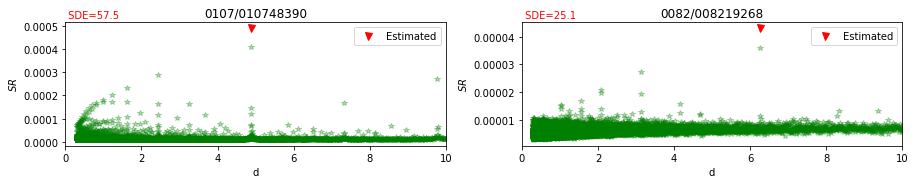

In [16]:
    freq = np.arange(fmin, df*nf+fmin, df)[0:nf]
    fig = plt.figure(figsize=(15,5))
    for j in range(0,nq):
        ax=fig.add_subplot(2,2,j+1)
        #ax.plot(Ptrue[j],0.0,"^",c="blue",markersize=7,label="Input")
        ax.plot(Pest[j],np.max(blsp[0+j*nf:nf+j*nf])*1.2,"v",c="red",markersize=7,label="Estimated")
        ax.legend()
        ax.plot(1/freq, blsp[0+j*nf:nf+j*nf], 'g*',alpha=0.3)
        plt.text(0.0,np.max(blsp[0+j*nf:nf+j*nf])*1.3," SDE="+str(round(sde[j],1)),color="red")
        plt.ylabel(r"$SR$")
        plt.title(dirlist[j].replace("/sharksuck/kic/data/",""))
        plt.xlabel("d")
        plt.xlim(0.,10)
    plt.show()

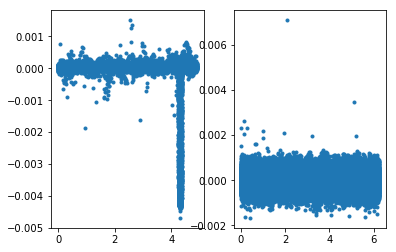

In [14]:
Ptrue=2.2047299
fig=plt.figure()
for j in range(0,2):
    ax=fig.add_subplot(1,2,j+1)
    tux=tu[:,j]
    ax.plot(np.mod(tux[tux>0.0],Pest[j]),imgout[:,j][tux>0.0],".")
plt.show()

In [17]:
    import blstest
    out1= np.zeros(nq*n).astype(np.float32)
    cuda.memcpy_dtoh(out1, dev_imgout)
    lc = out1.reshape((n,nq))
    tt=tu[:,0]
    mask=(tt>=0)
    #python-bls
    start = time.time()
    ntr, t0, ing, eg, f_1, blsx, nb, bper, bpow, depth, qtran, duration, in1, in2, phase1, phase2=\
    blstest.compute_bls(tt[mask], lc[:,0][mask], df, nf, nb, qmi, qma, fmin)
    #blstest.compute_bls(tu, imgout[:,0], df, nf, nb, qmi, qma, fmin)
        #blstest.compute_bls(tu, lc[:,0], df, nf, nb, qmi, qma, fmin)
    print(blsx)
    elapsed_time = time.time() - start
    print (("python-bls :{0}".format(elapsed_time)) + "[sec] for 1 LC")
    #print(len(np.arange(0.3, 0.001*nf+0.3, 0.001)),nf)

Complete
[  7.81578283e-06   1.18620269e-05   8.04386713e-06 ...,   5.25872687e-06
   3.69740227e-06   4.65947335e-06]
python-bls :8.595014095306396[sec] for 1 LC


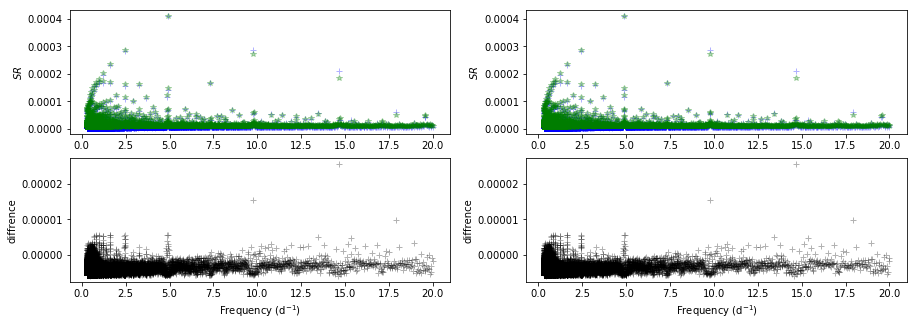

In [18]:
    freq = np.arange(fmin, df*nf+fmin, df)[0:nf]
    fig = plt.figure(figsize=(15,5))
    ax=fig.add_subplot(221)
    ax.plot(1/freq, blsx, 'b+',alpha=0.3)
    ax.plot(1/freq, blsp[0:nf], 'g*',alpha=0.3)
    plt.ylabel(r"$SR$")
    ax=fig.add_subplot(222)
    ax.plot(1/freq, blsx, 'b+',alpha=0.3)
    ax.plot(1/freq, blsp[0:nf], 'g*',alpha=0.3)
    plt.ylabel(r"$SR$")
    #plt.xlim(500,700)
    ax=fig.add_subplot(223)
    ax.plot(1/freq, (np.array(blsx)-np.array(blsp[0:nf])), 'k+',alpha=0.3)
    plt.ylabel("diffrence")
    plt.xlabel(r"Frequency (d$^{-1}$)")
    ax=fig.add_subplot(224)
    ax.plot(1/freq, (np.array(blsx)-np.array(blsp[0:nf])), 'k+',alpha=0.3)
    plt.ylabel("diffrence")
    plt.xlabel(r"Frequency (d$^{-1}$)")
    #plt.xlim(500,700)
    plt.show()